# Import

In [1]:
# Toy data 생성 및 시각화를 위한 라이브러리
import pandas as pd
import seaborn as sns
import torch
import random
import numpy as np
from torch.distributions.normal import Normal
import torch
from sklearn.preprocessing import MinMaxScaler
from torch import nn, optim  
from torch.utils.data import DataLoader, Dataset      # 데이터를 모델에 사용할 수 있게 정리해주는 라이브러리.
import torch.nn.functional as F  
import numpy as np
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import copy
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from random import randint   
from torch.utils.data import RandomSampler
from cdd import CDD

# DATA

In [2]:
import random
bn = 9
df_s =pd.read_csv("df_s_u.csv")
df_t =pd.read_csv("df_t_u.csv")
df_s_true =pd.read_csv("df_s_true_u.csv")
df_t_true =pd.read_csv("df_t_true_u.csv")
df_t_labeled =pd.read_csv("df_t_labeled_u.csv")

x_s = np.array(df_s['X']).tolist()
x_t = np.array(df_t['X']).tolist()
x_t_labeled = np.array(df_t_labeled['X']).tolist()
y_s = np.array(df_s['Y']).tolist()
y_t = np.array(df_t['Y']).tolist()
y_t_labeled = np.array(df_t_labeled['Y']).tolist()
y_s_true = np.array(df_s_true['Y']).tolist()
y_t_true = np.array(df_t_true['Y']).tolist()

<Axes: xlabel='X', ylabel='Y'>

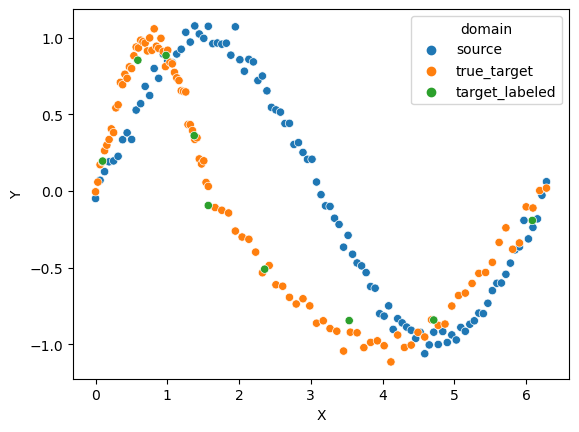

In [3]:
data_s = [[x_s[i],y_s[i],'source'] for i in range(len(x_s))]
df_s = pd.DataFrame(data_s, columns=['X','Y','domain'])


data_s_true = [[x_s[i],y_s_true[i],'source'] for i in range(len(x_s))]
df_s_true = pd.DataFrame(data_s_true, columns=['X','Y','domain'])
df_s_true = df_s_true.sort_values('X')

data_t = [[x_t[i],y_t[i],'true_target'] for i in range(len(x_t))]
df_t = pd.DataFrame(data_t, columns=['X','Y','domain'])

data_t_true = [[x_t[i],y_t_true[i],'true_target'] for i in range(len(x_t))]
df_t_true = pd.DataFrame(data_t_true, columns=['X','Y','domain'])

df_t_true = df_t_true.sort_values('X')
data_t_labeled = [[x_t_labeled[i],y_t_labeled[i],'target_labeled'] for i in range(len(x_t_labeled))]
df_t_labeled = pd.DataFrame(data_t_labeled, columns=['X','Y','domain'])

sns.scatterplot(data=pd.concat([df_s, df_t, df_t_labeled]), x= 'X', y='Y', hue='domain')

In [4]:
x_s = torch.tensor(x_s).reshape(-1,1).type(torch.float32)
x_t =torch.tensor(x_t).reshape(-1,1).type(torch.float32)
x_t_labeled =torch.tensor(x_t_labeled).reshape(-1,1).type(torch.float32)

In [5]:
y_s = torch.tensor(y_s).reshape(-1,1).type(torch.float32)
y_t =torch.tensor(y_t).reshape(-1,1).type(torch.float32)
y_t_labeled =torch.tensor(y_t_labeled).reshape(-1,1).type(torch.float32)
y_s_true = torch.tensor(y_s_true).reshape(-1,1).type(torch.float32)
y_t_true =torch.tensor(y_t_true).reshape(-1,1).type(torch.float32)

# Model

In [6]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.h1 = nn.Linear(1, 256)
        self.relu = nn.ReLU()
        self.h2 = nn.Linear(256, 256)
        self.h3 = nn.Linear(256, 256)
        self.h4 = nn.Linear(256,10)
        self.reg = nn.Linear(10, 1)
        self.drop1 = nn.Dropout()
        self.drop2 = nn.Dropout()
        
        
        
    def forward(self, x):
        h1_x = self.h1(x)
        h1_x = self.relu(h1_x)
        h1_x = self.h2(h1_x)
        h1_x = self.relu(h1_x)
        h1_x = self.h3(h1_x)
        h1_x = self.relu(h1_x)
        h1_x = self.drop1(h1_x)
        h1_x = self.h4(h1_x)
        h1_x = self.relu(h1_x)
        h1_x = self.drop2(h1_x)
        h1_x = self.reg(h1_x)

        return h1_x
    
    def output(self, x):
        h1_x = self.h1(x)
        h1_x = self.relu(h1_x)
        h1_x = self.h2(h1_x)
        h1_x = self.relu(h1_x)
        h1_x = self.h3(h1_x)
        h1_x = self.relu(h1_x)
        h1_x = self.h4(h1_x)
        f_x = self.relu(h1_x)
        y_hat = self.reg(h1_x)
        return {'f_x':f_x, 'output':y_hat}


# Pretrained Regressor

In [7]:
# model = Net()
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# best_loss = 1000
# for epoch in range(10000):
#     optimizer.zero_grad()

#     model_output_s = model.output(x_s)
#     latent_x_s = model_output_s['f_x']
#     y_s_hat = model_output_s['output']



#     # mse loss
#     y_s_mse = torch.nn.functional.mse_loss(y_s_hat, y_s)
#     y_s_mse.backward()
#     if epoch % 100 == 0:
#         print(f"Epoch : {epoch}, total_loss = {y_s_mse}")
#     optimizer.step()
#     val_loss = torch.nn.functional.mse_loss(y_s_hat, y_s_true)
#     if best_loss > val_loss:
#         best_loss = val_loss
#         best_model = copy.deepcopy(model)
#         print(f"Saving... val mse{val_loss}")
   
    

# Domain Shift -> performance effect

In [8]:
model = torch.load("./best_pretrained_model.pt")
model_output_s = model.output(x_s)
latent_x_s = model_output_s['f_x']
y_s_hat = model_output_s['output']

model_output_t_labeled = model.output(x_t_labeled)
latent_x_t_labeled = model_output_t_labeled['f_x']
y_t_labeled_hat = model_output_t_labeled['output']

model_output_t = model.output(x_t)
latent_x_t = model_output_t['f_x']
y_t_hat = model_output_t['output']

# mse loss
y_s_mse = torch.nn.functional.mse_loss(y_s_hat, y_s_true)
y_t_mse = torch.nn.functional.mse_loss(y_t_labeled_hat, y_t_labeled)
y_t_real_mse = torch.nn.functional.mse_loss(y_t_hat, y_t_true)

print(f"source mse : {y_s_mse}, labeled target mse : {y_t_mse}, target mse : {y_t_real_mse}")

source mse : 0.0012787054292857647, labeled target mse : 0.3967100977897644, target mse : 0.3313494026660919


<Axes: xlabel='X', ylabel='Y'>

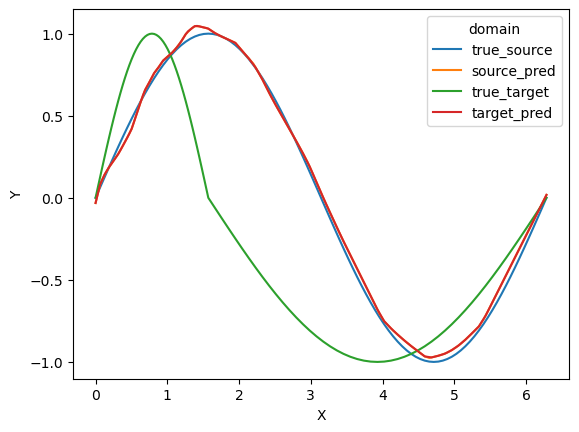

In [9]:
import seaborn as sns
data_s = [[x_s[i].item(),y_s_true[i].item(),'true_source'] for i in range(len(x_s))]
df_s = pd.DataFrame(data_s, columns=['X','Y','domain'])
df_s = df_s.sort_values('X')
data_s_hat = [[x_s[i].item(),y_s_hat[i].item(),'source_pred'] for i in range(len(x_s))]
df_s_hat = pd.DataFrame(data_s_hat, columns=['X','Y','domain'])
df_s_hat = df_s_hat.sort_values('X')

data_t = [[x_t[i].item(),y_t_true[i].item(),'true_target'] for i in range(len(x_t))]
df_t = pd.DataFrame(data_t, columns=['X','Y','domain'])
df_t = df_t.sort_values('X')
data_t_hat = [[x_t[i].item(),y_t_hat[i].item(),'target_pred'] for i in range(len(x_t))]
df_t_hat = pd.DataFrame(data_t_hat, columns=['X','Y','domain'])
df_t_hat = df_t_hat.sort_values('X')

df_total_labeled = pd.concat([df_s, df_s_hat, df_t,df_t_hat])
sns.lineplot(data=df_total_labeled, x='X', y='Y', hue='domain')

# Mapper

In [10]:
class Mapper(nn.Module):
    def __init__(self):
        super().__init__()
        self.h1 = nn.Linear(1, 16)
        self.relu = nn.ReLU()
        self.h2 = nn.Linear(16, 16)
        self.h3 = nn.Linear(16, 16)
        self.reg = nn.Linear(16, 1)
        
        
        
        
    def forward(self, x):
        h1_x = self.h1(x)
        h1_x = self.relu(h1_x)
        h1_x = self.h2(h1_x)
        h1_x = self.relu(h1_x)
        h1_x = self.h3(h1_x)
        h1_x = self.relu(h1_x)
        h1_x = self.reg(h1_x)


        return h1_x
    
    def output(self, x):
        h1_x = self.h1(x)
        h1_x = self.relu(h1_x)
        h1_x = self.h2(h1_x)
        h1_x = self.relu(h1_x)
        h1_x = self.h3(h1_x)
        f_x = self.relu(h1_x)
        y_hat = self.reg(h1_x)
        return {'f_x':f_x, 'output':y_hat}


In [11]:
list1 = [[1,6],[1,7],[1,8],[1,9],[1,10]]
list2 = []
for i in range(len(list1)):
    list2.append(list1[i][0]/list1[i][1])
    list2.append(2*list1[i][0]/(list1[i][0]+list1[i][1]))
    list2.append(2*list1[i][1]/(list1[i][0]+list1[i][1]))
loss_hyper = pd.DataFrame(np.array(list2).reshape(-1,3))
loss_hyper #alpha/beta


,0,1,2
0,0.166667,0.285714,1.714286
1,0.142857,0.250000,1.750000
2,0.125000,0.222222,1.777778
3,0.111111,0.200000,1.800000
4,0.100000,0.181818,1.818182


In [12]:
for hyperparameter in range(len(loss_hyper)):
    alpha = loss_hyper.iloc[hyperparameter,1]
    beta = loss_hyper.iloc[hyperparameter,2]
    mapper = Mapper()
    optimizer = optim.Adam(mapper.parameters(), lr=0.0001)
    best_mapper = copy.deepcopy(mapper)
    best_loss = 1000
    loss_list = []
    for epoch in range(20000):
        optimizer.zero_grad()

        latent_x_s = x_s
        
        mapper_output_t_labeled = mapper.output(x_t_labeled)
        latent_x_t_labeled = mapper_output_t_labeled['output']
        
        
        # source latent에서 batch 추출
        batch_latent_x_s_index = torch.randperm(latent_x_s.size(0))[:bn]
        batch_latent_x_s = latent_x_s[batch_latent_x_s_index]


        # cdd loss
        feats_toalign_S = [batch_latent_x_s, torch.tensor([1]).repeat(len(batch_latent_x_s),1)]
        feats_toalign_T = [latent_x_t_labeled, torch.tensor([1]).repeat(len(latent_x_t_labeled),1)]
        cdd = CDD(kernel_num=(10,10), kernel_mul=(2,2), num_layers=2, num_classes=1, intra_only=True)
        cdd_loss = cdd.forward(feats_toalign_S, feats_toalign_T, [bn], [bn])['cdd']

        # ns loss
        epsilon_k = 3

        f_s_vector = latent_x_s
        f_t_vector = latent_x_t_labeled

        from sklearn.neighbors import KNeighborsRegressor
        knn = KNeighborsRegressor(n_neighbors=epsilon_k)
        knn.fit(y_s, np.array(range(len(y_s))))
        total_ns_loss = 0
        for i in range(bn):
            best_dist = 1000
            error = 0
            neighbors = knn.kneighbors(y_t_labeled[i].reshape(-1,1))[1][0].tolist()
            for index_i in neighbors:
                temp_f_dist = torch.abs(f_t_vector[i] - f_s_vector[index_i]).norm()
                temp_y_dist = torch.abs(y_t_labeled[i] - y_s[index_i]).norm()
                if best_dist > temp_f_dist + temp_y_dist:
                    best_dist = temp_f_dist + temp_y_dist
                    error = temp_f_dist
            total_ns_loss += error
        ns_loss = total_ns_loss / bn

        total_loss = alpha*cdd_loss + beta*ns_loss
        
        if best_loss > total_loss:
            best_loss = total_loss
            best_mapper = copy.deepcopy(mapper)
        total_loss.backward()

        loss_list.append(total_loss.item())
        if epoch % 100 == 0:
            print(f"Epoch : {epoch}, total_loss = {np.mean(np.array(loss_list))}")
            loss_list = []
        optimizer.step()
    
    torch.save(best_mapper, f"./best_mapper_u_16_110_{hyperparameter}.pt")

Epoch : 0, total_loss = 6.569809913635254
Epoch : 100, total_loss = 5.410714769363404
Epoch : 200, total_loss = 4.65597984790802
Epoch : 300, total_loss = 3.6556990456581118
Epoch : 400, total_loss = 2.5249027514457705
Epoch : 500, total_loss = 2.1298841989040374
Epoch : 600, total_loss = 1.539590699672699
Epoch : 700, total_loss = 1.3338328993320465
Epoch : 800, total_loss = 1.288392848968506
Epoch : 900, total_loss = 1.3168902218341827
Epoch : 1000, total_loss = 1.321874157190323
Epoch : 1100, total_loss = 1.3001258063316345
Epoch : 1200, total_loss = 1.2999158275127412
Epoch : 1300, total_loss = 1.244385837316513
Epoch : 1400, total_loss = 1.21194589138031
Epoch : 1500, total_loss = 1.2478622460365296
Epoch : 1600, total_loss = 1.2138072890043259
Epoch : 1700, total_loss = 1.139111683368683
Epoch : 1800, total_loss = 1.0121330881118775
Epoch : 1900, total_loss = 1.015121733546257
Epoch : 2000, total_loss = 0.9566965126991271
Epoch : 2100, total_loss = 0.9335128688812255
Epoch : 2200

# Domain Adaptation -> Performance

In [13]:
source_mse, labeled_target_mse, target_mse, source_r2, target_r2 = [],[],[],[],[]
for i in range(len(loss_hyper)):
    best_mapper = torch.load(f"./best_mapper_u_16_110_{i}.pt")
    
    model_output_s = model.output(x_s)
    latent_x_s = model_output_s['f_x']
    y_s_hat = model_output_s['output']

    f_t_labeled = best_mapper.output(x_t_labeled)['output']
    model_output_t_labeled = model.output(f_t_labeled)
    latent_x_t_labeled = model_output_t_labeled['f_x']
    y_t_labeled_hat = model_output_t_labeled['output']

    f_t = best_mapper.output(x_t)['output']
    model_output_t = model.output(f_t)
    latent_x_t = model_output_t['f_x']
    y_t_hat = model_output_t['output']

    # mse loss
    y_s_mse = torch.nn.functional.mse_loss(y_s_hat, y_s_true)
    y_t_mse = torch.nn.functional.mse_loss(y_t_labeled_hat, y_t_labeled)
    y_t_real_mse = torch.nn.functional.mse_loss(y_t_hat, y_t_true)

    from torcheval.metrics import R2Score
    metric = R2Score()
    metric.update(y_s_hat, y_s_true)
    y_s_r2 = metric.compute()

    metric = R2Score()
    metric.update(y_t_hat, y_t_true)
    y_t_r2 = metric.compute()

    print(f"source mse : {y_s_mse}, labeled target mse : {y_t_mse}, target mse : {y_t_real_mse}")
    print(f"source r2 : {y_s_r2}, target r2 : {y_t_r2}")

    source_mse.append(y_s_mse)
    labeled_target_mse.append(y_t_mse)
    target_mse.append(y_t_real_mse)
    source_r2.append(y_s_r2)
    target_r2.append(y_t_r2)

source mse : 0.0012787054292857647, labeled target mse : 0.003405634080991149, target mse : 0.0055247098207473755
source r2 : 0.9974170327186584, target r2 : 0.9888401031494141
source mse : 0.0012787054292857647, labeled target mse : 0.0035016825422644615, target mse : 0.0019914216827601194
source r2 : 0.9974170327186584, target r2 : 0.9959773421287537
source mse : 0.0012787054292857647, labeled target mse : 0.003459489904344082, target mse : 0.0018934305990114808
source r2 : 0.9974170327186584, target r2 : 0.9961752891540527
source mse : 0.0012787054292857647, labeled target mse : 0.0034346962347626686, target mse : 0.002160164061933756
source r2 : 0.9974170327186584, target r2 : 0.9956364631652832
source mse : 0.0012787054292857647, labeled target mse : 0.0034773291554301977, target mse : 0.0031293807551264763
source r2 : 0.9974170327186584, target r2 : 0.993678629398346


,ratio,labeled_target_mse
0,0.166667,0.003406
1,0.142857,0.003502
2,0.125000,0.003459
3,0.111111,0.003435
4,0.100000,0.003477


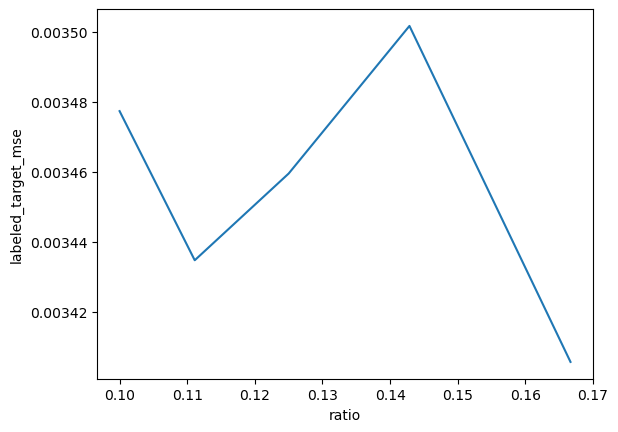

In [14]:
list_mse = []
for i in range(len(loss_hyper)):
    list_mse.append(labeled_target_mse[i].item())

df_mse = pd.concat([loss_hyper.iloc[:,0],pd.DataFrame(list_mse)],axis=1,ignore_index=True)
df_mse.rename({0:'ratio',1:'labeled_target_mse'},axis=1,inplace=True)

sns.lineplot(data=df_mse, x = 'ratio',y= 'labeled_target_mse')
df_mse

In [15]:
# import seaborn as sns
# data_s = [[x_s[i].item(),y_s_true[i].item(),'true_source'] for i in range(len(x_s))]
# df_s = pd.DataFrame(data_s, columns=['X','Y','domain'])
# df_s = df_s.sort_values('X')
# data_s_hat = [[x_s[i].item(),y_s_hat[i].item(),'source_pred'] for i in range(len(x_s))]
# df_s_hat = pd.DataFrame(data_s_hat, columns=['X','Y','domain'])
# df_s_hat = df_s_hat.sort_values('X')

# data_t = [[x_t[i].item(),y_t_true[i].item(),'true_target'] for i in range(len(x_t))]
# df_t = pd.DataFrame(data_t, columns=['X','Y','domain'])
# df_t = df_t.sort_values('X')
# data_t_hat = [[x_t[i].item(),y_t_hat[i].item(),'target_pred'] for i in range(len(x_t))]
# df_t_hat = pd.DataFrame(data_t_hat, columns=['X','Y','domain'])
# df_t_hat = df_t_hat.sort_values('X')

# df_total_labeled = pd.concat([df_s, df_s_hat, df_t,df_t_hat])
# sns.lineplot(data=df_total_labeled, x='X', y='Y', hue='domain')

In [16]:
# model_output_s = model.output(x_s)
# latent_x_s = model_output_s['f_x']
# y_s_hat = model_output_s['output']

# f_t_labeled = mapper.output(x_t_labeled)['output']
# model_output_t_labeled = model.output(f_t_labeled)
# latent_x_t_labeled = model_output_t_labeled['f_x']
# y_t_labeled_hat = model_output_t_labeled['output']

# f_t = mapper.output(x_t)['output']
# model_output_t = model.output(f_t)
# latent_x_t = model_output_t['f_x']
# y_t_hat = model_output_t['output']

# # mse loss
# y_s_mse = torch.nn.functional.mse_loss(y_s_hat, y_s)
# y_t_mse = torch.nn.functional.mse_loss(y_t_labeled_hat, y_t_labeled)
# y_t_real_mse = torch.nn.functional.mse_loss(y_t_hat, y_t)

# from torcheval.metrics import R2Score
# metric = R2Score()
# metric.update(y_s_hat, y_s_true)
# y_s_r2 = metric.compute()

# metric = R2Score()
# metric.update(y_t_hat, y_t_true)
# y_t_r2 = metric.compute()

# print(f"source mse : {y_s_mse}, labeled target mse : {y_t_mse}, target mse : {y_t_real_mse}")
# print(f"source r2 : {y_s_r2}, target r2 : {y_t_r2}")

In [17]:
# import seaborn as sns
# data_s = [[x_s[i].item(),y_s_true[i].item(),'true_source'] for i in range(len(x_s))]
# df_s = pd.DataFrame(data_s, columns=['X','Y','domain'])
# df_s = df_s.sort_values('X')
# data_s_hat = [[x_s[i].item(),y_s_hat[i].item(),'source_pred'] for i in range(len(x_s))]
# df_s_hat = pd.DataFrame(data_s_hat, columns=['X','Y','domain'])
# df_s_hat = df_s_hat.sort_values('X')

# data_t = [[x_t[i].item(),y_t_true[i].item(),'true_target'] for i in range(len(x_t))]
# df_t = pd.DataFrame(data_t, columns=['X','Y','domain'])
# df_t = df_t.sort_values('X')
# data_t_hat = [[x_t[i].item(),y_t_hat[i].item(),'target_pred'] for i in range(len(x_t))]
# df_t_hat = pd.DataFrame(data_t_hat, columns=['X','Y','domain'])
# df_t_hat = df_t_hat.sort_values('X')

# df_total_labeled = pd.concat([df_s, df_s_hat, df_t,df_t_hat])
# sns.lineplot(data=df_total_labeled, x='X', y='Y', hue='domain')

In [18]:
# 1% MMD + NS (Mapper 3구간 1점)
# 3.3% MMD + NS (Mapper 3구간)
# 3.3% 5*MMD + NS [BEST] (Mapper 3구간 MMD5배)
# 3.3% NS (Mapper 3구간 NS만)
# 3.3% MMD (Mapper 3구간 MMD만)
# 6.6% MMD + NS (Mapper 3구간 6점6)
# 3.3% Shared(MMD+NS+MSE) (Shared_30)
# 3.3%(True Target X -> 15, 10, 5) MMD+NS (Mapper 3구간 분포변화)
# 3.3%(True Target X -> 15, 10, 5) 5*MMD+NS (Mapper 3구간 분포변화 MMD5배)
# 3.3%(True Target X -> 15, 10, 5) 1/2*MMD+NS [NOT BAD] (Mapper 3구간 분포변화 MMD반)

# NS만 하거나 MMD만 하는 것보단, 둘다 하는 것이 좋다

# Sample Target ~~ True Target => MMD의 계수 높일수록 좋고
# Sample Target ~!~ True Target => MMD의 계수를 낮출수록 좋다 

In [19]:
print("0929 15:00 현재 시각 ? 끝까지 다 돌림 !")

0929 15:00 현재 시각 ? 끝까지 다 돌림 !
